In [2]:
%matplotlib inline

import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

## Monte-Carlo simulation of 2D Ising model
The code in the first part of this exercise simulates the Ising model in 2D using the Metropolis algorithm. The main steps of the Metropolis algorithm are:
    1. Prepare an initial configuration of N spins
    2. Flip the spin of a randomly chosen lattice site.
    3. Calculate the change in energy dE
    4. if dE < 0, accept the move
    5. if dE >= 0 accept the move with probability $$e^{-dE/T}$$
    6. repeat 2-5

In [18]:
class Ising():
    ''' simulate the Ising Model '''   
    
    def __init__(self, N, temp):
        self.N = N
        self.temp = temp
        self.states = []

    def mc_move(self, config, N, beta):
        ''' execute the monte carlo moves using Metropolis algorithm '''
        for i in range(N):
            for j in range(N):
                    # choose a random lattice site
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    
                    # get the spin of this site
                    s =  config[a, b]
                    
                    # get the spins of the neighbors of this site
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    
                    # this part does not entirely resemble how it is done in the exercise
                    hamiltonian = 2*s*nb
                    
                    # accept if energy change is negative
                    if hamiltonian < 0:
                        # update spin
                        config[a, b] = -1*s
                    # otherwise accept if random number is smaller
                    elif rand() < np.exp(-hamiltonian*beta):
                        # update spin
                        config[a, b] = -1*s
                    
        return config
    
    def simulate(self, mc_steps):
        """ execute the monte carlo moves and save some states """
        
        # initialize grid
        i = 0
        config = 2*np.random.randint(2, size=(self.N,self.N))-1
        self.states.append([np.copy(config), i, 1])
        
        # simulate
        for i in range(1, mc_steps):
            # do a monte carlo move
            self.mc_move(config, self.N, 1.0/self.temp)
            
            # save states at certain time points
            if i == 1:       self.states.append([np.copy(config), i, 2])
            if i == 4:       self.states.append([np.copy(config), i, 3])
            if i == 32:      self.states.append([np.copy(config), i, 4])
            if i == 100:     self.states.append([np.copy(config), i, 5])
            if i == 1000:    self.states.append([np.copy(config), i, 6])
                 
                    
    def plot(self):
        """ plot the states that have been saved """
        
        fig = plt.figure(figsize=(15, 15), dpi=80)
        
        X, Y = np.meshgrid(range(self.N), range(self.N))
        
        for state in self.states:
            sp =  fig.add_subplot(3, 3, state[2] )  
            plt.setp(sp.get_yticklabels(), visible=False)
            plt.setp(sp.get_xticklabels(), visible=False)      
            plt.pcolormesh(X, Y, state[0], cmap="Set1")
            i = state[1]
            plt.title('Time=%d'%i)
            plt.axis('tight')
        
        plt.show()
        
    def plot_final(self):
        """ plot the final state """
        
        fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        X, Y = np.meshgrid(range(self.N), range(self.N))
        
        state = self.states[-1]   

        plt.pcolormesh(X, Y, state[0], cmap="Set1")
        i = state[1]
        plt.title('Time=%d'%i)
        plt.axis('tight')
        
        plt.show()
        

In [19]:
N = 50 # lattice sites
temp = .4 # temperature in the simulation
mc_steps = 1001 # amount of monte carlo steps

model = Ising(N, temp)
model.simulate(mc_steps)

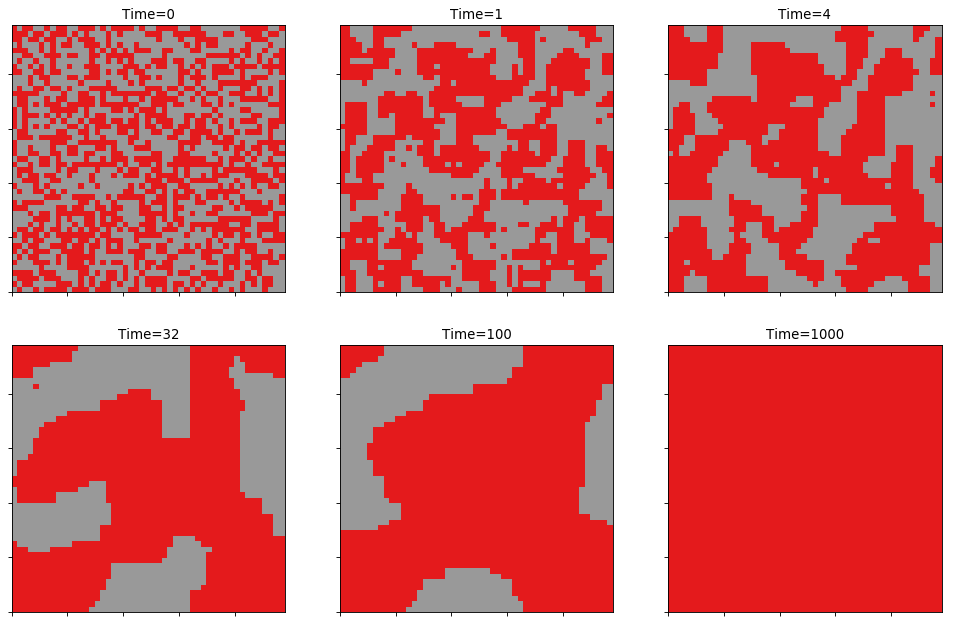

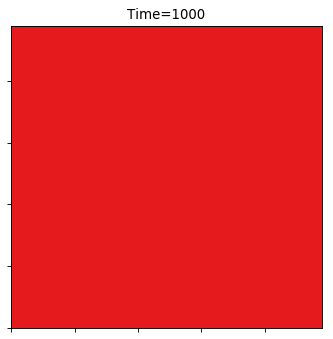

In [20]:
model.plot()
model.plot_final()

In [21]:
N = 50 # lattice sites
temp = .4 # temperature in the simulation
mc_steps = 1001 # amount of monte carlo steps

model2 = Ising(N, temp)
model2.simulate(mc_steps)

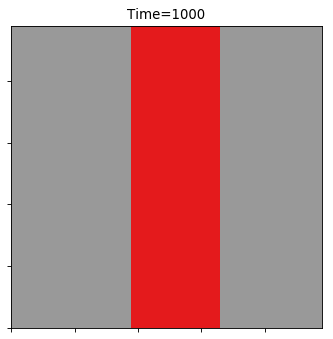

In [22]:
model2.plot_final()

We see different final states. The simulation can end up in entirely 1 spin type (which makes the most sense, because this has the lowest energy in nature), or in a steady state with a band of one spin type, and the rest the other type. 

(Two examples are needed here........ can we save initial states to be sure to end up in a certain end state?)

# And then...
After building the Ising Model in Python, we continued with the Cellular Potts model. This generalizes the Ising model from statistical mechanics and it shares its core idea of modeling dynamics based on energy minimzation under imposed fluctuations. 

We need now to take into account two state per cell, the cell ID and the cell type.  We associate an integer index to each lattice site to identify the space a cell occupies at any instant. The value of the index at a pixel (i, j) is k if the site lies in the cell k. Collections of pixels with the same index represent cells. We treat a cell as a set of discrete subcomponents that can rearrange to produce cell motion and shape changes. As long as we can describe a process in terms of a real or effective potential energy, we can include it in the CPM framework by adding it up to the effective energy. Cells can move up or down gradients of both diffusible chemicals (chemotaxis) and insoluble extracellular matrix molecules (haptotaxis). The CPM models chemotaxis and haptotaxis by adding a chemical potential energy, cell growth by target volumes of cells and cell division by a specific reassignment of pixes. If a proposed change in lattice configuration changes the effective energy by dE, we accept the change with probability:


Save time: reject spin atteps inside a cell

Cells can span more than one lattice site, and we need to plot the cell type and the boundaries between individual cells.

In [37]:
class Cell():
    ''' cell class with its corresponding properties '''
    
    def __init__(self, cellId, cellType):
        self.id = cellId
        self.type = cellType 
        
    def __str__(self):
        return f'id: {self.id}, type: {self.type}'

class CellularPotts():
    ''' simulate the Cellular Potts '''   
    
    def __init__(self, N, temp):
        self.N = N
        self.temp = temp
        self.states = []
    
                
    def mc_move(self, config, N, beta):
        ''' execute the monte carlo moves using Metropolis algorithm '''
        for i in range(N):
            for j in range(N):
                    # choose a random lattice site
                    a = np.random.randint(0, N)
                    b = np.random.randint(0, N)
                    
                    # get the spin of this site
                    s =  config[a, b]
                    
                    # get the spins of the neighbors of this site
                    nb = config[(a+1)%N,b] + config[a,(b+1)%N] + config[(a-1)%N,b] + config[a,(b-1)%N]
                    
                    # this part does not entirely resemble how it is done in the exercise
                    hamiltonian = 2*s*nb
                    
                    # accept if energy change is negative
                    if hamiltonian < 0:
                        # update spin
                        config[a, b] = -1*s
                    # otherwise accept if random number is smaller
                    elif rand() < np.exp(-hamiltonian*beta):
                        # update spin
                        config[a, b] = -1*s
                    
        return config
    
    def simulate(self, mc_steps):
        """ execute the monte carlo moves and save some states """
        
        # initialize grid
        i = 0
        config = 2*np.random.randint(2, size=(self.N,self.N))-1
        cell = Cell(cellIdi,cellType='no idea')
        self.states.append([cell, i, 1])
        
        # simulate
        for i in range(1, mc_steps):
            # do a monte carlo move
            self.mc_move(config, self.N, 1.0/self.temp)
            
            # save states at certain time points
            if i == 1:       self.states.append([np.copy(config), i, 2])
            if i == 4:       self.states.append([np.copy(config), i, 3])
            if i == 32:      self.states.append([np.copy(config), i, 4])
            if i == 100:     self.states.append([np.copy(config), i, 5])
            if i == 1000:    self.states.append([np.copy(config), i, 6])
                 
                    
    def plot(self):
        """ plot the states that have been saved """
        
        fig = plt.figure(figsize=(15, 15), dpi=80)
        
        X, Y = np.meshgrid(range(self.N), range(self.N))
        
        for state in self.states:
            sp =  fig.add_subplot(3, 3, state[2] )  
            plt.setp(sp.get_yticklabels(), visible=False)
            plt.setp(sp.get_xticklabels(), visible=False)      
            plt.pcolormesh(X, Y, state[0], cmap="Set2")
            i = state[1]
            plt.title('Time=%d'%i)
            plt.axis('tight')
        
        plt.show()
        
    def plot_final(self):
        """ plot the final state """
        
        fig, ax = plt.subplots(figsize=(5, 5), dpi=80)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        X, Y = np.meshgrid(range(self.N), range(self.N))
        
        state = self.states[-1]   

        plt.pcolormesh(X, Y, state[0], cmap="Set2")
        i = state[1]
        plt.title('Time=%d'%i)
        plt.axis('tight')
        
        plt.show()

In [38]:
N = 50 # lattice sites
temp = .4 # temperature in the simulation
mc_steps = 1001 # amount of monte carlo steps

model = CellularPotts(N, temp)
model.simulate(mc_steps)

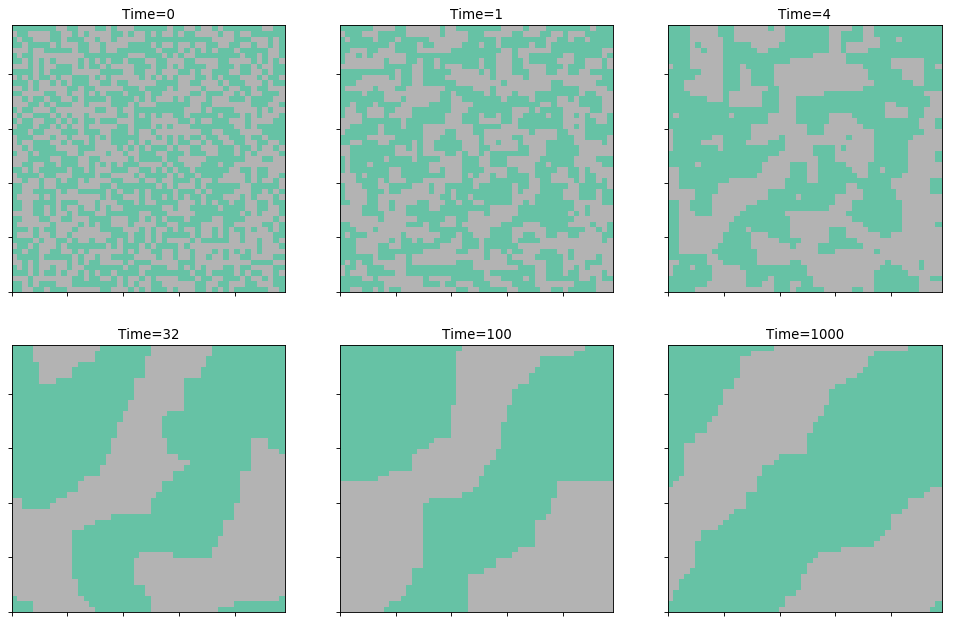

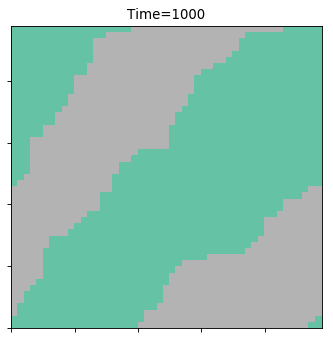

In [39]:
model.plot()
model.plot_final()